In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, Linear, CFlow
from flows.config import floatX
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.02
m1 = 0.
s0 = 0.5
dim = [3,4]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params, dtype=floatX)

PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1, sigma0=s0)

In [3]:
params.shape, params[0,0,0]

((32, 3, 4), 0.23571758186624653)

In [4]:
def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(d, X) + param[:,-1] + np.random.normal(size=[3], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(d, X) + param[:,-1]
    return X

In [5]:
xs = [np.random.normal(size=dim[0])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.array(xs)[np.newaxis,:].astype(floatX)

In [6]:
xs

array([[[ 0.19346423, -0.49674494,  1.03272322],
        [ 0.75089704, -0.24004044,  1.56023568],
        [ 1.33432254, -0.10471606,  1.71865807],
        [ 1.54588873, -0.20818525,  1.68364877],
        [ 1.68148556, -0.37411808,  1.76172681],
        [ 2.09740197, -0.45182008,  1.99430704],
        [ 2.25823839, -0.52564708,  2.29149912],
        [ 2.51989736, -0.19371303,  2.83614621],
        [ 3.01852404,  0.0583006 ,  2.54984082],
        [ 2.71668602, -0.09782482,  2.09575982],
        [ 2.26981822, -0.40068235,  2.1594381 ],
        [ 2.45664852, -0.60831159,  2.43140573],
        [ 2.77512522, -0.65634492,  3.04094299],
        [ 3.60274281, -0.54669109,  3.49500891],
        [ 3.98640836, -0.60954206,  3.69219046],
        [ 4.33092643, -0.86453493,  4.03100531],
        [ 4.83079726, -0.98160696,  4.45837677],
        [ 5.35334207, -1.01985258,  5.04855488],
        [ 6.06093529, -0.76130638,  5.7114181 ],
        [ 6.64303079, -0.56710145,  6.04413233],
        [ 7.00183397

In [7]:
# conf = [[ResFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)), 
#          NVPFlow(dim=n*dim[0]*dim[1], name='nvp{}'.format(i))] for i in range(2)]
# conf = sum(conf, [])

#conf = [NVPFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)) for i in range(4)]
#conf = [Linear(dim=n*dim[0]*dim[1])]
conf = [CFlow(dim=n*dim[0]*dim[1], name='CFlow')]

output_flow = DFlow(conf)

In [8]:
output_flow.output

<tf.Variable 'CFlow/W:0' shape=(384,) dtype=float64_ref>

In [9]:
outputs = tf.reshape(output_flow.output, [1,n,dim[0]*dim[1]])

In [10]:
outputs

<tf.Tensor 'Reshape:0' shape=(1, 32, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs, mean=True)

In [12]:
#outputs = tf.cast(outputs, tf.float64)

In [13]:
prior

<tf.Tensor 'add_2:0' shape=() dtype=float64>

In [14]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][:,np.newaxis], out[i])
        ll += obs_d.logdens(pred, full_reduce=True, mean=True)
    return ll

In [15]:
logl = create_loglik()

In [16]:
xs.shape

(1, 32, 3)

In [17]:
logl

<tf.Tensor 'add_95:0' shape=() dtype=float64>

In [18]:
ent = output_flow.logdens

In [19]:
ent

0

In [20]:
loss = -logl + ent - prior
loss /= n*dim[0]*dim[1]

In [21]:
opt = tf.train.AdamOptimizer(0.001).minimize(loss)

In [22]:
sess = tf.InteractiveSession()

In [23]:
tf.global_variables_initializer().run()

In [24]:
logl.eval(), prior.eval()

(-98285.87983894628, 2.538087512742216)

In [25]:
loss.eval()

255.9462024776915

In [26]:
stage = 0

In [27]:
for stage in range(stage, stage+60):
    for _ in range(900):
        l, _ = sess.run([loss, opt], {phase:True})
    print(stage, l)

0 96.8570831448522
1 79.66754848515504
2 65.44639314191714
3 53.5667567846237
4 43.63137938954528
5 35.30905549318637
6 28.331500432481594
7 22.492824933069524
8 17.634077052483615
9 13.626316710710263
10 10.358979932129673
11 7.733110654138787
12 5.65753788573121
13 4.048101543115935
14 2.8289586043573594
15 1.932987464501817
16 1.2998429975607075
17 0.8739960250891561
18 0.6062416805978249
19 0.4541126304064766
20 0.38114673271293004
21 0.3552741409997248
22 0.3496026305598045
23 0.34877510520989535
24 0.34843074623812914
25 0.3479770141559764
26 0.3473163451167103
27 0.3464080155094738
28 0.34523661736445543
29 0.3438681007665266
30 0.342455789482297
31 0.34117543827261115
32 0.340160958059033
33 0.33945922817325025
34 0.33903198228350667
35 0.3388003551989274
36 0.3386914538735841
37 0.3386414610344313
38 0.3386194677532846
39 0.33860880037943675
40 0.33860270559995165
41 0.33859832273419327
42 0.33859536220596126
43 0.33859297963709456
44 0.3385910054707612
45 0.33859044391457543


In [28]:
out = tf.reshape(outputs, [n, 3, 4])

In [29]:
samples = []
for _ in range(10):
    s = out.eval()
    samples.append([s[3,2,3], s[4,2,3]])
samples = np.array(samples)

LinAlgError: singular matrix

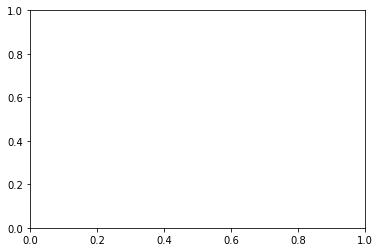

In [32]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

In [30]:
params[0,2,3]

0.4959730111713389

In [31]:
samples[:,0].mean()

0.8618814279606699

In [37]:
a = params[16]

In [38]:
b = out.eval()[16]

In [39]:
a.sum(axis=0)

array([-0.08164042, -1.43486447,  1.87682645, -0.079015  ])

In [40]:
b.sum(axis=0)

array([ 0.14766024, -0.86871647,  1.6657364 ,  0.39039458])